In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from forecasting_utils import *




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    ap

In [2]:
df_processed = pd.read_csv('data/processed_FRED_Data.csv')
df_processed.head()
variables = list(df_processed.select_dtypes(include=[np.number]).columns)

### Forecasting Benchmark Implementation:

To conduct the sampling of RMSEs for each variable under each forecast horizion for each model, we will do the following:
- Starting with forecast h=1 and a a 70-30 training-test split, we will iterate over each variable and employ forecasting with horizion h. In other words, starting at quarter i into the time series data, we will forcast the next h quarters. At the time time, we use a univariate AR(1) model to forecast the same next h quarters.

- We will then calculate the RMSE beteween the actual and forecasted values for each variable. We do the same between the AR(1) predicted and actual values. We devide each RSME by the AR(1) RMSE for each respective variable. This is one obvervation.

- We then forecast the next h quarters starting at quarter i+1 into the time series and calculate the RMSE of the forecast for each variable relative to the AR(1), and take its average. This is the second observation. in other words, we have shifted 1 quarter out of the test set and into the training set.

- We repeat this process until 95% of the data is in the training set.

- From these obvervations we will take the mean, std, min, max, q25, q75, and iqr. These are the summary statistics for the models RMSE relative to AR(1) with horizion h.

- We then repeat the process for h=3, h=6, and h=12.

- We then repeat the process for each model.

**For TimeGPT, we will shift the training-test split by 2% of the data each iteration due to API limits

In [3]:
horizons = ["h=1", "h=3", "h=6", "h=12"]
models = ['BVAR', 'ARIMA', 'TimeGPT', 'TimesFM', 'LagLlama', 'Moirai']
variables = list(df_processed.select_dtypes(include=[np.number]).columns)
results = {
    h:{
        model: {
            'RMSE': [],
            'cum_RMSE': {var:[] for var in variables},
        } for model in models
    } for h in horizons

}
results

{'h=1': {'BVAR': {'RMSE': [],
   'cum_RMSE': {'GDP_log': [],
    'XTIMVA01USM664S_log': [],
    'XTEXVA01USM664S_log': [],
    'GPDI_log': [],
    'RPI_log': [],
    'INDPRO_log': [],
    'BUSLOANS_log': [],
    'NONREVSL_log': [],
    'UNRATE_diff': [],
    'DFF_diff': [],
    'GS1_diff': [],
    'AAA_diff': [],
    'IRLTLT01USM156N_diff': [],
    'M1V': [],
    'CUMFNS': [],
    'CLF16OV': [],
    'B235RC1Q027SBEA': [],
    'ROWFDIQ027S': [],
    'CPILFESL_inflation': [],
    'PCEPI_inflation': []}},
  'ARIMA': {'RMSE': [],
   'cum_RMSE': {'GDP_log': [],
    'XTIMVA01USM664S_log': [],
    'XTEXVA01USM664S_log': [],
    'GPDI_log': [],
    'RPI_log': [],
    'INDPRO_log': [],
    'BUSLOANS_log': [],
    'NONREVSL_log': [],
    'UNRATE_diff': [],
    'DFF_diff': [],
    'GS1_diff': [],
    'AAA_diff': [],
    'IRLTLT01USM156N_diff': [],
    'M1V': [],
    'CUMFNS': [],
    'CLF16OV': [],
    'B235RC1Q027SBEA': [],
    'ROWFDIQ027S': [],
    'CPILFESL_inflation': [],
    'PCEPI_inflatio

### AR(1) Benchmark

In [51]:
# Example usage:
target_variable = 'GDP_log'
# Try different AR orders
train_data, test_data, _ = test_train_split(df_processed, test_size=0.3)
print(run_ar_benchmark(train_data, test_data, target_variable, ar_order=1))

test_size = 0.3
train_size = int(len(df_processed)*(1-test_size))
train_data = df_processed.iloc[:train_size]
test_data = df_processed.iloc[train_size:]

rmse_ratios = []
cum_rmse_ratios = []
cum_sum = 0
while train_size < len(df_processed):
    rmse, _ = run_ar_benchmark(train_data, test_data, target_variable, ar_order=1)
    rmse_ratios.append(rmse)
    cum_sum += rmse
    cum_rmse_ratios.append(cum_sum)
    train_size += 1
    train_data = df_processed.iloc[:train_size]
    test_data = df_processed.iloc[train_size:]

print(rmse_ratios)
print(cum_rmse_ratios)


(np.float64(0.16468619654459926), np.float64(12.943444703403303))
[np.float64(0.16468619654459926), np.float64(0.16250361469519423), np.float64(0.16709981604875138), np.float64(0.16733425350665368), np.float64(0.17690977688652543), np.float64(0.1738545995435857), np.float64(0.16710811307418771), np.float64(0.1655420291036693), np.float64(0.16452436678833035), np.float64(0.16435533214522124), np.float64(0.1618566132761411), np.float64(0.1583452033650232), np.float64(0.141040586126496), np.float64(0.1385377426788484), np.float64(0.1255541517461678), np.float64(0.08688777090930884), np.float64(0.059966840514587956), np.float64(0.045329089761454076), np.float64(0.039841187449081966), np.float64(0.041434055019705734), np.float64(0.03878115770194905), np.float64(0.04073284417227213), np.float64(0.040218853603509915), np.float64(0.03997322353821258), np.float64(0.03564408238784127), np.float64(0.036599990346282474), np.float64(0.03497196449465718), np.float64(0.03548310163218589), np.float64(

### Bayesian Vector Autoregression (BVAR)

In [82]:
df_processed = df_processed.select_dtypes(include=[np.number])



for h in [1,3,6,12]:
    print("Forecasting on horizon: " + str(h))
    test_size = 0.3
    train_size = int(len(df_processed)*(1-test_size))
    train_data = df_processed.iloc[:train_size]
    test_data = df_processed.iloc[train_size:]

    current_cum_sums ={var:0 for var in variables}
    while len(test_data) > 13:
        rsmes = []
        for var in variables:
            rmse, _ = fit_evaluate_bvar(train_data, test_data, var, h)
            ar_rmse, _ = run_ar_benchmark(train_data, test_data, var, ar_order=1)
            rsmes.append(rmse/ar_rmse)
            current_cum_sums[var] += rmse
            #print(current_cum_sums[var])  
            results["h="+str(h)]['BVAR']['cum_RMSE'][var].append(current_cum_sums[var])

        results["h="+str(h)]['BVAR']['RMSE'].append(np.mean(rsmes))

        train_size += 1
        train_data = df_processed.iloc[:train_size]
        test_data = df_processed.iloc[train_size:]

results


Forecasting on horizon: 1
Forecasting on horizon: 3
Forecasting on horizon: 6
Forecasting on horizon: 12


{'h=1': {'BVAR': {'RMSE': [np.float64(2.0692348096731354),
    np.float64(1.8747706081316342),
    np.float64(2.125200625746204),
    np.float64(1.9359814750809057),
    np.float64(1.6575047557577338),
    np.float64(1.9912650224044246),
    np.float64(1.955733909670539),
    np.float64(1.915053644681264),
    np.float64(1.9548199859099484),
    np.float64(1.9541856705028617),
    np.float64(1.8850866522899097),
    np.float64(1.8944766460455231),
    np.float64(2.448202093277191),
    np.float64(2.1672932970626237),
    np.float64(2.5660662490727844),
    np.float64(3.241449691221397),
    np.float64(4.926834428113545),
    np.float64(2.248590570441783),
    np.float64(2.780686456751957),
    np.float64(2.3446671869590356),
    np.float64(2.0929997475890336),
    np.float64(2.2626856164465075),
    np.float64(2.5577936923313436),
    np.float64(1.8910860563222756),
    np.float64(2.035322625869676),
    np.float64(2.142153427703757),
    np.float64(2.204499591198249),
    np.float64(2

### ARIMA

In [83]:
for h in [1,3,6,12]:
    print("Forecasting on horizon: " + str(h))
    test_size = 0.3
    train_size = int(len(df_processed)*(1-test_size))
    train_data = df_processed.iloc[:train_size]
    test_data = df_processed.iloc[train_size:]

    current_cum_sums ={var:0 for var in variables}
    while len(test_data) > 13:
        rsmes = []
        for var in variables:
            rmse, _ = fit_evaluate_arima(var, train_data, test_data, h)
            ar_rmse, _ = run_ar_benchmark(train_data, test_data, var, ar_order=1)
            rsmes.append(rmse/ar_rmse)
            current_cum_sums[var] += rmse
            #print(current_cum_sums[var])  
            results["h="+str(h)]['ARIMA']['cum_RMSE'][var].append(current_cum_sums[var])

        results["h="+str(h)]['ARIMA']['RMSE'].append(np.mean(rsmes))

        train_size += 1
        train_data = df_processed.iloc[:train_size]
        test_data = df_processed.iloc[train_size:]

results

Forecasting on horizon: 1
Forecasting on horizon: 3
Forecasting on horizon: 6
Forecasting on horizon: 12


{'h=1': {'BVAR': {'RMSE': [np.float64(2.0692348096731354),
    np.float64(1.8747706081316342),
    np.float64(2.125200625746204),
    np.float64(1.9359814750809057),
    np.float64(1.6575047557577338),
    np.float64(1.9912650224044246),
    np.float64(1.955733909670539),
    np.float64(1.915053644681264),
    np.float64(1.9548199859099484),
    np.float64(1.9541856705028617),
    np.float64(1.8850866522899097),
    np.float64(1.8944766460455231),
    np.float64(2.448202093277191),
    np.float64(2.1672932970626237),
    np.float64(2.5660662490727844),
    np.float64(3.241449691221397),
    np.float64(4.926834428113545),
    np.float64(2.248590570441783),
    np.float64(2.780686456751957),
    np.float64(2.3446671869590356),
    np.float64(2.0929997475890336),
    np.float64(2.2626856164465075),
    np.float64(2.5577936923313436),
    np.float64(1.8910860563222756),
    np.float64(2.035322625869676),
    np.float64(2.142153427703757),
    np.float64(2.204499591198249),
    np.float64(2

### TimeGPT 

Multiseries Forecast:
https://docs.nixtla.io/docs/capabilities-forecast-multiple_series_forecasting



In [3]:
pip install -Uqq nixtla datasetsforecast utilsforecast

Note: you may need to restart the kernel to use updated packages.


In [4]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-Q6bqxtnGbhVX0aqgWPvnwwnAIeyRk4dSJJELRDUBnoYwYnsaUBh1rHTpzhgdX5Bdp9wUCmpyB83SYhIo'
)

'\nMultiseries Forecast:\n'

In [24]:
# Prepare data for TimeGPT by reshaping from wide to long format
def prepare_data_for_timegpt(df):
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Rename the date column to 'ds'
    df = df.rename(columns={'observation_date': 'ds'})
    
    # Get list of numeric columns (these will be our variables to forecast)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Melt the dataframe to convert from wide to long format
    df_long = pd.melt(
        df,
        id_vars=['ds'],
        value_vars=numeric_columns,
        var_name='unique_id',
        value_name='y'
    )
    
    # Sort by unique_id and date
    df_long = df_long.sort_values(['unique_id', 'ds'])
    
    return df_long

# Apply the transformation
df_timegpt = prepare_data_for_timegpt(df_processed)

# Display the first few rows of the transformed data
print("Shape of transformed data:", df_timegpt.shape)
print("\nFirst few rows of transformed data:")
print(df_timegpt.head())

# Display unique variables being forecast
print("\nUnique variables being forecast:")
print(df_timegpt['unique_id'].unique())

Shape of transformed data: (5160, 3)

First few rows of transformed data:
              ds unique_id         y
2838  1960-04-01  AAA_diff -0.273408
2839  1960-07-01  AAA_diff -0.381349
2840  1960-10-01  AAA_diff  0.023429
2841  1961-01-01  AAA_diff -0.138482
2842  1961-04-01  AAA_diff  0.023429

Unique variables being forecast:
['AAA_diff' 'B235RC1Q027SBEA' 'BUSLOANS_log' 'CLF16OV'
 'CPILFESL_inflation' 'CUMFNS' 'DFF_diff' 'GDP_log' 'GPDI_log' 'GS1_diff'
 'INDPRO_log' 'IRLTLT01USM156N_diff' 'M1V' 'NONREVSL_log'
 'PCEPI_inflation' 'ROWFDIQ027S' 'RPI_log' 'UNRATE_diff'
 'XTEXVA01USM664S_log' 'XTIMVA01USM664S_log']


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint


Detailed RMSE for each variable and horizon:
                           h=1       h=3       h=6      h=12
AAA_diff              0.272894  0.757237  1.138258  0.986416
B235RC1Q027SBEA       0.005867  0.027384  0.027113  0.044816
BUSLOANS_log          0.001587  0.004985  0.010132  0.028655
CLF16OV               0.006262  0.014483  0.020641  0.043631
CPILFESL_inflation    0.248947  0.312809  0.271593  0.213795
CUMFNS                0.213008  0.319672  0.361284  0.527186
DFF_diff              0.154628  0.104243  0.150475  0.861566
GDP_log               0.010782  0.008962  0.007690  0.008245
GPDI_log              0.041507  0.035884  0.031597  0.053894
GS1_diff              0.416252  0.242166  0.369437  1.287004
INDPRO_log            0.015318  0.027999  0.021189  0.031244
IRLTLT01USM156N_diff  0.253626  0.654173  0.818467  0.755995
M1V                   0.031304  0.084470  0.197843  0.381511
NONREVSL_log          0.011493  0.012048  0.013093  0.021212
PCEPI_inflation       0.309412  0.34690

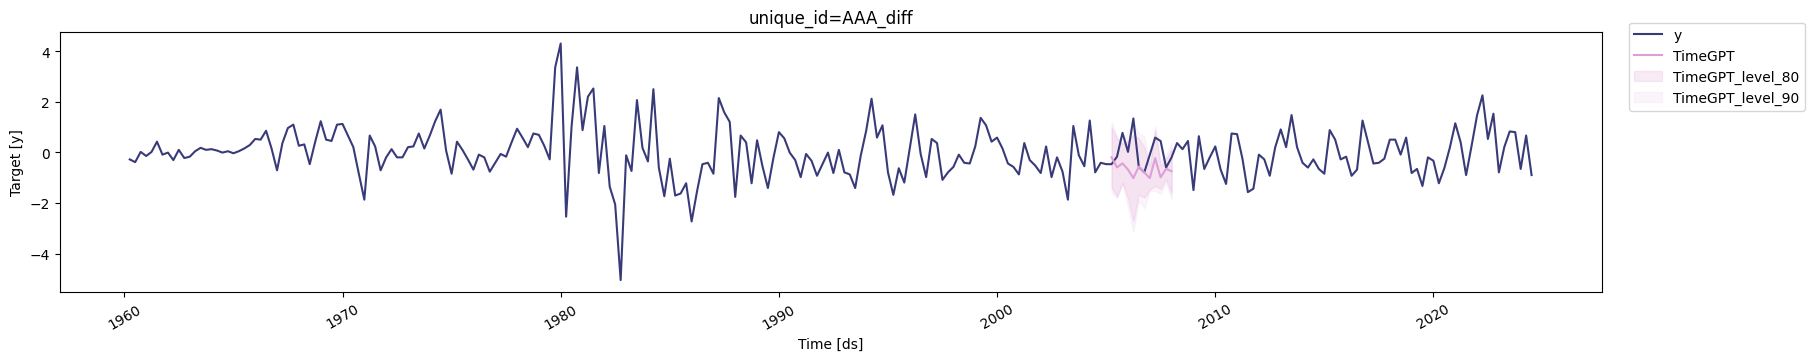

In [25]:
def run_timegpt(df_long, df_transformed, ratio=0.7):
    # Create a copy to avoid modifying the original
    df = df_long.copy()
    
    # Split data into train and test
    split_idx = int(len(df['ds'].unique()) * ratio)
    train_dates = sorted(df['ds'].unique())[:split_idx]
    
    train_data = df[df['ds'].isin(train_dates)]
    test_data = df[~df['ds'].isin(train_dates)]
    
    # Horizons to evaluate
    horizons = [1, 3, 6, 12]
    results = {}
    
    for h in horizons:
        # Generate forecast
        forecast_df = nixtla_client.forecast(
            df=train_data,
            h=h,
            level=[80, 90]
        )
        
        # Calculate RMSE and statistics for each variable
        horizon_results = {}
        rmse_values = []  # Store all RMSE values for this horizon
        
        # Calculate metrics for each unique_id (variable)
        for var in df['unique_id'].unique():
            # Get actual values for this horizon and variable
            var_test = test_data[test_data['unique_id'] == var]['y'].iloc[:h].values
            # Get predictions for this variable
            var_pred = forecast_df[forecast_df['unique_id'] == var]['TimeGPT'].values
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(var_test, var_pred))
            horizon_results[var] = rmse
            ar1_mse, _ = run_ar_benchmark(df_transformed, var, ar_order=1)
            ratio = rmse/ar1_mse
            rmse_values.append(ratio)
        
        # Calculate statistics for this horizon
        rmse_array = np.array(rmse_values)
        horizon_results['mean_rmse'] = np.mean(rmse_array)
        horizon_results['std_rmse'] = np.std(rmse_array)
        horizon_results['min_rmse'] = np.min(rmse_array)
        horizon_results['max_rmse'] = np.max(rmse_array)
        horizon_results['q25_rmse'] = np.percentile(rmse_array, 25)
        horizon_results['q75_rmse'] = np.percentile(rmse_array, 75)
        horizon_results['iqr_rmse'] = horizon_results['q75_rmse'] - horizon_results['q25_rmse']
            
        results[f'h={h}'] = horizon_results
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame(results)
    
    # Create a summary DataFrame with just the statistics
    stats_cols = ['mean_rmse', 'std_rmse', 'min_rmse', 'max_rmse', 
                  'q25_rmse', 'q75_rmse', 'iqr_rmse']
    stats_df = results_df.loc[stats_cols]
    
    return results_df, stats_df, forecast_df

# Example usage:
results_df, stats_df, last_forecast = run_timegpt(df_timegpt, df_processed)

# Print results
print("\nDetailed RMSE for each variable and horizon:")
print(results_df)
print("\nRMSE Statistics Summary:")
print(stats_df)

# Optional: Plot the last forecast for a specific variable
variable_to_plot = df_timegpt['unique_id'].unique()[0]  # First variable
var_data = df_timegpt[df_timegpt['unique_id'] == variable_to_plot]
var_forecast = last_forecast[last_forecast['unique_id'] == variable_to_plot]

nixtla_client.plot(
    var_data, 
    var_forecast,
    max_insample_length=365, 
    level=[80, 90]
)

In [26]:
print(stats_df)

                h=1       h=3       h=6      h=12
mean_rmse  0.243734  0.296455  0.367336  0.611443
std_rmse   0.216107  0.285313  0.372807  0.610190
min_rmse   0.004719  0.022027  0.021809  0.036049
max_rmse   0.741616  0.946709  1.423067  2.292991
q25_rmse   0.059715  0.052336  0.136529  0.225811
q75_rmse   0.343033  0.404266  0.392273  0.742202
iqr_rmse   0.283317  0.351930  0.255745  0.516391


/var/folders/3b/mhjd36px23sbt4q9lkdqwy_r0000gn/T/ipykernel_36385/985025450.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([data[h] for h in horizons], labels=horizons)


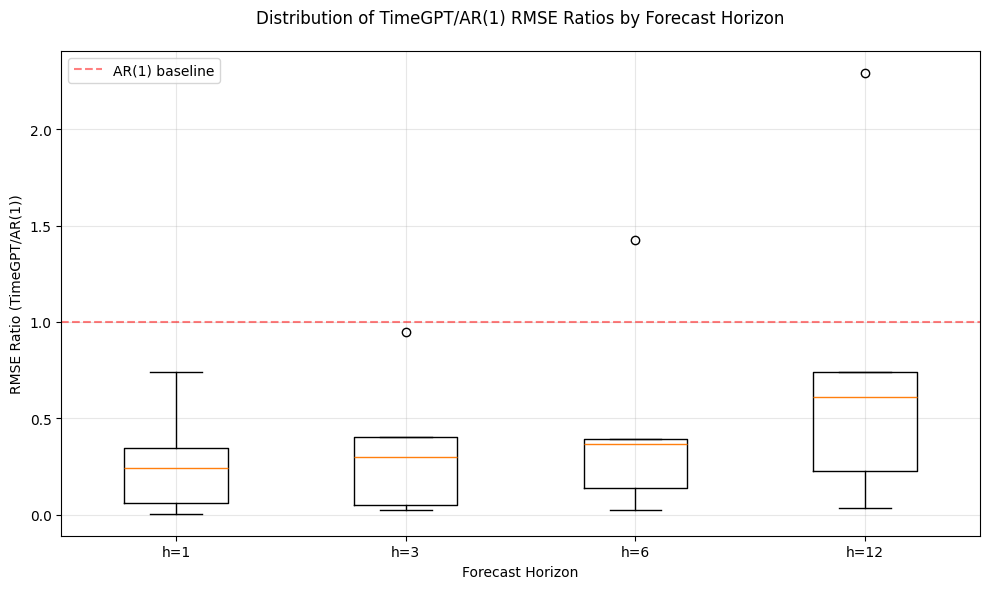

In [27]:
# Create data for boxplot
horizons = ['h=1', 'h=3', 'h=6', 'h=12']
data = {
    'h=1': [0.004719, 0.741616, 0.059715, 0.343033, 0.243734],  # min, max, q25, q75, median(mean)
    'h=3': [0.022027, 0.946709, 0.052336, 0.404266, 0.296455],
    'h=6': [0.021809, 1.423067, 0.136529, 0.392273, 0.367336],
    'h=12': [0.036049, 2.292991, 0.225811, 0.742202, 0.611443]
}

# Create figure and axis
plt.figure(figsize=(10, 6))

# Create boxplot
bp = plt.boxplot([data[h] for h in horizons], labels=horizons)

# Add horizontal line at y=1 to show AR(1) baseline
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='AR(1) baseline')

# Customize plot
plt.title('Distribution of TimeGPT/AR(1) RMSE Ratios by Forecast Horizon', pad=20)
plt.ylabel('RMSE Ratio (TimeGPT/AR(1))')
plt.xlabel('Forecast Horizon')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### TimesFM

Github: https://github.com/google-research/timesfm

In [1]:
!pip -q install huggingface_hub[cli] utilsforecast praxis paxml jax[cpu]==0.4.26 einshape

ERROR: Cannot install jax==0.4.26, jax[cpu]==0.4.26, praxis==0.1, praxis==0.2.0, praxis==0.2.1, praxis==0.3.0, praxis==0.4.0, praxis==1.0.0, praxis==1.1.0, praxis==1.2.0, praxis==1.3.0, praxis==1.3.1 and praxis==1.4.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [5]:
!pip install -e git+https://github.com/google-research/timesfm.git@master#egg=timesfm

Obtaining timesfm from git+https://github.com/google-research/timesfm.git@master#egg=timesfm
  Cloning https://github.com/google-research/timesfm.git (to revision master) to ./.venv/src/timesfm
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm.git /Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/src/timesfm
  Resolved https://github.com/google-research/timesfm.git to commit cec7fb4d43fbd1eb1d4630a80a2165bbe1ae3829
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (31 kB)
  Using cached typer-0.15.2-py3-none-any.whl.metadata (15 kB)
  Using cached wandb-0.19.8-py3-none-macosx_11_0_x86_64.whl.metadata (10 kB)
  Using cached InquirerPy-0.3.4-py3-none-any.whl

In [1]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. This error is frequently encountered on macOS when running an x86 Python installation on ARM hardware. In this case, try installing an ARM build of Python. Otherwise, you may be able work around this issue by building jaxlib from source.

In [ ]:
import timesfm

def run_timesfm(train_data, test_data, performance_tracker):
    # Initialize TimesFM
    model = TimesFM(
        forecast_length=len(test_data),
        backcast_length=len(train_data),
        batch_size=32
    )
    
    # Train model
    model.fit(
        train_data,
        epochs=100,
        validation_data=test_data
    )
    
    # Make predictions
    predictions = model.predict(test_data)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data[target_column], predictions))
    r2 = r2_score(test_data[target_column], predictions)
    mape = np.mean(np.abs((test_data[target_column] - predictions) / test_data[target_column])) * 100
    
    # Track performance
    performance_tracker.add_metric('TimesFM', rmse, r2, mape)

### LagLlama

In [1]:
cd /Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/lag-llama

/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/lag-llama


/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install -U -r requirements.txt

  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)


In [3]:
cd /Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/lag-llama

/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/lag-llama


In [7]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/lag-llama

/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/lag-llama/lag-llama.ckpt


In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [19]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [12]:
# Get list of numeric columns (these will be our variables to forecast)
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns

# Melt the dataframe to convert from wide to long format
df_long = pd.melt(
    df_processed,
    id_vars=['observation_date'],
    value_vars=numeric_columns,
    var_name='item_id',
    value_name='target'
)

# Sort by item_id and date
df_long = df_long.sort_values(['item_id', 'observation_date'])

# Set the date as index without a name
df_long = df_long.set_index('observation_date', drop=True)
df_long.index.name = None

# Display the first few rows to verify the transformation
print("Shape of transformed data:", df_long.shape)
print("\nFirst few rows of transformed data:")
print(df_long.head())

Shape of transformed data: (5160, 2)

First few rows of transformed data:
             item_id    target
1960-04-01  AAA_diff -0.273408
1960-07-01  AAA_diff -0.381349
1960-10-01  AAA_diff  0.023429
1961-01-01  AAA_diff -0.138482
1961-04-01  AAA_diff  0.023429


In [20]:
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()
for col in df_long.columns:
    # Check if column is not of string type
    if df_long[col].dtype != 'object' and pd.api.types.is_string_dtype(df_long[col]) == False:
        df_long[col] = df_long[col].astype('float32')
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")
print(dataset)

PandasDataset<size=10, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>


In [21]:
forecasts, tss = get_lag_llama_predictions(dataset, 12, torch.device("cpu"))
print(forecasts)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL gluonts.torch.distributions.studentT.StudentTOutput was not an allowed global by default. Please use `torch.serialization.add_safe_globals([StudentTOutput])` or the `torch.serialization.safe_globals([StudentTOutput])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

### Moirai

Github: https://github.com/SalesforceAIResearch/uni2ts

In [117]:
from moirai import Moirai

def run_moirai(train_data, test_data, performance_tracker):
    # Initialize Moirai
    model = Moirai(
        input_size=train_data.shape[1],
        forecast_horizon=len(test_data)
    )
    
    # Train model
    model.fit(train_data)
    
    # Make predictions
    predictions = model.predict(len(test_data))
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data[target_column], predictions))
    r2 = r2_score(test_data[target_column], predictions)
    mape = np.mean(np.abs((test_data[target_column] - predictions) / test_data[target_column])) * 100
    
    # Track performance
    performance_tracker.add_metric('Moirai', rmse, r2, mape)

ModuleNotFoundError: No module named 'moirai'

### Plot Distirbution of RMSEs for each model and horizon

### Plot Cumulative RMSEs for each model and variable

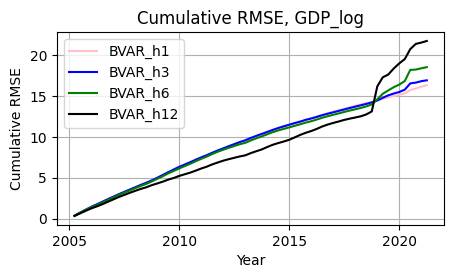

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

train_data, test_data, _ = test_train_split(df_processed, test_size=0.3)
# Sample Data
dates = test_data[:-13].index
values = results["h=12"]['BVAR']['cum_RMSE']['GDP_log']  # Replace with your actual data

# Create DataFrame
df = pd.DataFrame({"Date": dates, 
                   "BVAR_h1": results["h=1"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h1": results["h=1"]['ARIMA']['cum_RMSE']['GDP_log'],
                   "BVAR_h3": results["h=3"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h3": results["h=3"]['ARIMA']['cum_RMSE']['GDP_log'],
                   "BVAR_h6": results["h=6"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h6": results["h=6"]['ARIMA']['cum_RMSE']['GDP_log'],
                   "BVAR_h12": results["h=12"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h12": results["h=12"]['ARIMA']['cum_RMSE']['GDP_log']
                   })

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.plot(df["Date"], df["BVAR_h1"], color="pink", linestyle="-")
ax.plot(df["Date"], df["BVAR_h3"], color="blue", linestyle="-")
ax.plot(df["Date"], df["BVAR_h6"], color="green", linestyle="-")
ax.plot(df["Date"], df["BVAR_h12"], color="black", linestyle="-")

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Tick every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show only year

# Labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative RMSE")
ax.set_title("Cumulative RMSE, GDP_log")
ax.legend(["BVAR_h1", "BVAR_h3", "BVAR_h6", "BVAR_h12"])
plt.grid()
plt.show()


65
65
